# 6. Train Deep Learning Models

## 1. Prepare Data for Deep Learning

### We’ll use tokenization + padding for text input.

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt

In [57]:
fake_news_df = pd.read_csv("../data/processed/balanced_fake_news_dataset.csv")


## 1. Data Preparation


In [58]:
# Data inspection
print("Dataset shape:", fake_news_df.shape)
print("Columns:", fake_news_df.columns.tolist())
print("\nLabel distribution:")
print(fake_news_df['label'].value_counts())


Dataset shape: (62030, 8)
Columns: ['text', 'label', 'original_label', 'dataset', 'clean_text', 'tokens', 'processed_text', 'sentiment']

Label distribution:
label
1    31042
0    30988
Name: count, dtype: int64


In [59]:
# Tokenization
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(fake_news_df['clean_text'])
sequences = tokenizer.texts_to_sequences(fake_news_df['clean_text'])
padded = pad_sequences(sequences, padding='post', maxlen=200)

labels = fake_news_df['label'].values

In [60]:
# Check if labels need encoding (if they're strings like 'fake'/'real')
if labels.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    print(f"\nLabel encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


In [61]:
# Three-way split: Train (60%), Validation (20%), Test (20%)
# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    padded, labels, 
    test_size=0.2, 
    random_state=42,
    stratify=labels  # Maintain label distribution
)

In [62]:
# Second split: train (75% of remaining = 60% total) and validation (25% of remaining = 20% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 25% of 80% = 20% of total
    random_state=42,
    stratify=y_temp
)


In [63]:
# Print split information
print("\nData split:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(padded)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(padded)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(padded)*100:.1f}%)")


Data split:
Training set: 37218 samples (60.0%)
Validation set: 12406 samples (20.0%)
Test set: 12406 samples (20.0%)


In [64]:
# Check class distribution in each split
print(f"\nClass distribution:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Train: {dict(zip(unique_train, counts_train))}")
print(f"Validation: {dict(zip(unique_val, counts_val))}")
print(f"Test: {dict(zip(unique_test, counts_test))}")


Class distribution:
Train: {0: 18592, 1: 18626}
Validation: {0: 6198, 1: 6208}
Test: {0: 6198, 1: 6208}


In [65]:
# Vocabulary information
vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")
print(f"Using vocab size: {min(vocab_size, 10000)}")


Vocabulary size: 216911
Using vocab size: 10000


In [66]:
# Sample data inspection
print("\nSample shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nFirst sequence sample length: {len([x for x in X_train[0] if x != 0])}")


Sample shapes:
X_train shape: (37218, 200)
y_train shape: (37218,)
X_val shape: (12406, 200)
y_val shape: (12406,)
X_test shape: (12406, 200)
y_test shape: (12406,)

First sequence sample length: 200


## 2. LSTM Model

In [67]:
# Build the LSTM model
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile with improved learning rate
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# Model summary
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
model_lstm.summary()


MODEL ARCHITECTURE
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 675137 (2.58 MB)
Trainable params: 675137 (2.58 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________

In [68]:
# Enhanced callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Increased patience since we're using lower LR
    restore_best_weights=True, 
    verbose=1
)
# Add learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      # Reduce LR by 80% when plateau detected
    patience=3,      # Wait 3 epochs before reducing
    min_lr=1e-6,     # Minimum learning rate
    verbose=1
)

In [69]:
# Your model training (now with validation data)
history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Now you have validation data!
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# Final evaluation on unseen test data
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)
print("\nFinal Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/20
1164/1164 [==============================] - 97s 82ms/step - loss: 0.5539 - accuracy: 0.6974 - val_loss: 0.4159 - val_accuracy: 0.7537 - lr: 1.0000e-04
Epoch 2/20
1164/1164 [==============================] - 102s 88ms/step - loss: 0.3811 - accuracy: 0.7626 - val_loss: 0.3808 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 3/20
1164/1164 [==============================] - 119s 102ms/step - loss: 0.3402 - accuracy: 0.8061 - val_loss: 0.3624 - val_accuracy: 0.7886 - lr: 1.0000e-04
Epoch 4/20
1164/1164 [==============================] - 126s 108ms/step - loss: 0.2979 - accuracy: 0.8485 - val_loss: 0.3180 - val_accuracy: 0.8435 - lr: 1.0000e-04
Epoch 5/20
1164/1164 [==============================] - 125s 107ms/step - loss: 0.2706 - accuracy: 0.8688 - val_loss: 0.3342 - val_accuracy: 0.8276 - lr: 1.0000e-04
Epoch 6/20
1164/1164 [==============================] - 123s 106ms/step - loss: 0.2527 - accuracy: 0.8793 - val_loss: 0.3169 - val_accuracy: 0.8484 - lr: 1.0000e-04
Epoch 7/20
11

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot learning rate changes
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], color='green')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNot Recorded', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
    
    # Plot overfitting indicator
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    overfitting_gap = [val - train for val, train in zip(val_loss, train_loss)]
    
    axes[1, 1].plot(overfitting_gap, color='red', linewidth=2)
    axes[1, 1].set_title('Overfitting Gap (Val Loss - Train Loss)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


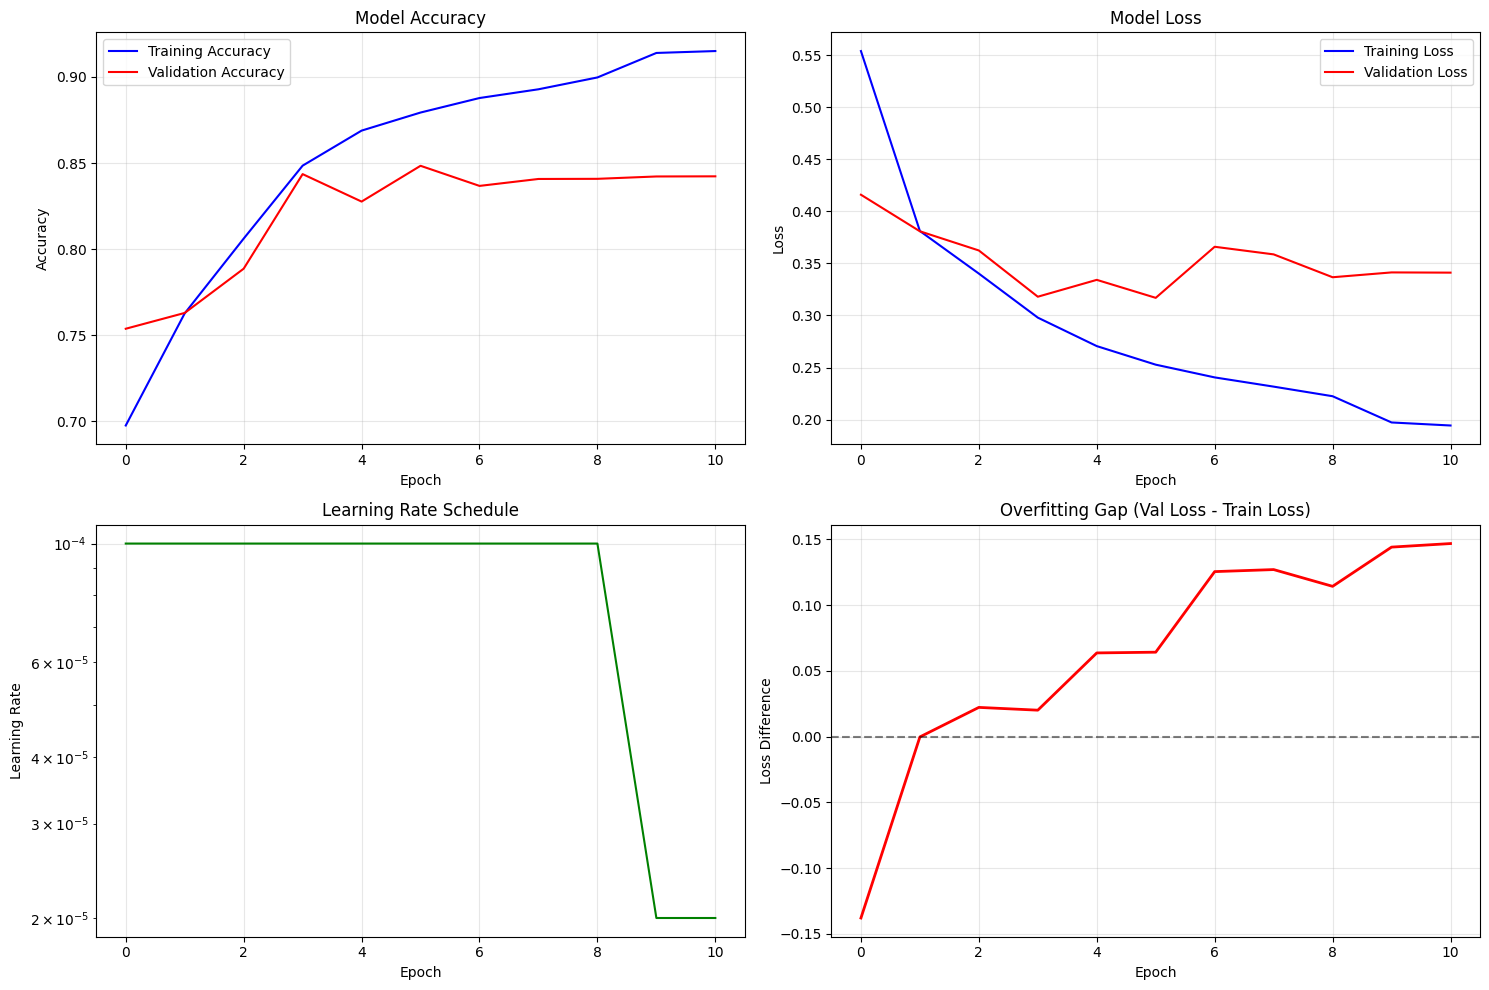

In [91]:
plot_training_history(history)

In [72]:
# Evaluate on test set
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)

In [73]:
# Print comprehensive results
print("\n" + "="*60)
print("FINAL TRAINING RESULTS")
print("="*60)
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Total Epochs Trained: {len(history.history['loss'])}")

if 'lr' in history.history:
    print(f"Final Learning Rate: {history.history['lr'][-1]:.2e}")


FINAL TRAINING RESULTS
Best Validation Accuracy: 0.8484
Best Validation Loss: 0.3169
Final Test Accuracy: 0.8474
Final Test Loss: 0.3148
Total Epochs Trained: 11
Final Learning Rate: 2.00e-05


In [76]:
# Compare with your original results
print("\n" + "="*60)
print("COMPARISON WITH ORIGINAL RESULTS")
print("="*60)
print("Original Results (from your first training):")
print("- Best Val Accuracy: ~0.7355")
print("- Showed overfitting after epoch 3")
print("- Training plateaued early")
print("\nNew Results:")
print(f"- Test Accuracy: {test_accuracy:.4f}")
print(f"- Training completed in {len(history.history['loss'])} epochs")
print(f"- {'Improved!' if test_accuracy > 0.7355 else 'Try further adjustments'}")


COMPARISON WITH ORIGINAL RESULTS
Original Results (from your first training):
- Best Val Accuracy: ~0.7355
- Showed overfitting after epoch 3
- Training plateaued early

New Results:
- Test Accuracy: 0.8474
- Training completed in 11 epochs
- Improved!


In [77]:
# Model predictions sample (optional)
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)
sample_predictions = model_lstm.predict(X_test[:5])
for i, (pred, actual) in enumerate(zip(sample_predictions, y_test[:5])):
    pred_class = "Fake" if pred[0] > 0.5 else "Real"
    actual_class = "Fake" if actual == 1 else "Real"
    confidence = pred[0] if pred[0] > 0.5 else 1 - pred[0]
    print(f"Sample {i+1}: Predicted={pred_class} ({confidence:.3f}), Actual={actual_class}")


SAMPLE PREDICTIONS
1/1 [==============================] - 1s 512ms/step
Sample 1: Predicted=Fake (0.998), Actual=Fake
Sample 2: Predicted=Fake (0.794), Actual=Fake
Sample 3: Predicted=Fake (0.996), Actual=Fake
Sample 4: Predicted=Fake (0.901), Actual=Fake
Sample 5: Predicted=Real (0.791), Actual=Real


In [78]:
from tensorflow import keras

In [80]:
# # 2. Save the entire model
# model_lstm.save('../models/fnd_lstm_model.keras') # Recommended .keras extension for Keras 3+
# # Or for older versions/TensorFlow SavedModel format:
# # model.save('my_lstm_model.h5') # HDF5 format
# # model.save('my_lstm_model_tf_savedmodel') # TensorFlow SavedModel directory

# print("Model saved successfully!")

Model saved successfully!


## 3. CNN

In [82]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

In [83]:
# Build the CNN model with improvements
model_cnn = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),  # Increased dropout for better regularization
    Dense(64, activation='relu'),  # Increased dense layer size
    Dropout(0.3),  # Additional dropout
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [84]:
# Compile with optimized learning rate
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [85]:
# Model summary
print("="*60)
print("CNN MODEL ARCHITECTURE")
print("="*60)
model_cnn.summary()

CNN MODEL ARCHITECTURE
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          41088     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                               

In [86]:
# Enhanced Callbacks

# Early stopping with increased patience
early_stop_cnn = EarlyStopping(
    monitor='val_loss', 
    patience=7,  # Higher patience for CNN
    restore_best_weights=True, 
    verbose=1
)

# Learning rate scheduler
lr_scheduler_cnn = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      # Reduce LR by 80%
    patience=3,      # Wait 3 epochs before reducing
    min_lr=1e-6,     # Minimum learning rate
    verbose=1
)

In [88]:
# Train with proper validation split (X_val, y_val instead of X_test, y_test)
history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use validation set, not test set!
    epochs=25,  # More epochs with early stopping
    batch_size=32,  # Smaller batch size for better convergence
    callbacks=[early_stop_cnn, lr_scheduler_cnn],
    verbose=1
)

Epoch 1/25
1164/1164 [==============================] - 31s 26ms/step - loss: 0.6560 - accuracy: 0.5905 - val_loss: 0.4744 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 2/25
1164/1164 [==============================] - 30s 26ms/step - loss: 0.4114 - accuracy: 0.8036 - val_loss: 0.3469 - val_accuracy: 0.8314 - lr: 1.0000e-04
Epoch 3/25
1164/1164 [==============================] - 30s 25ms/step - loss: 0.3236 - accuracy: 0.8564 - val_loss: 0.3241 - val_accuracy: 0.8440 - lr: 1.0000e-04
Epoch 4/25
1164/1164 [==============================] - 31s 26ms/step - loss: 0.2799 - accuracy: 0.8806 - val_loss: 0.3196 - val_accuracy: 0.8498 - lr: 1.0000e-04
Epoch 5/25
1164/1164 [==============================] - 31s 26ms/step - loss: 0.2522 - accuracy: 0.8981 - val_loss: 0.3246 - val_accuracy: 0.8476 - lr: 1.0000e-04
Epoch 6/25
1164/1164 [==============================] - 31s 26ms/step - loss: 0.2252 - accuracy: 0.9103 - val_loss: 0.3343 - val_accuracy: 0.8493 - lr: 1.0000e-04
Epoch 7/25
1163/1164 [

In [89]:
# RESULTS VISUALIZATION
# ================================

def plot_cnn_training_history(history, model_name="CNN"):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    axes[0, 0].set_title(f'{model_name} Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    axes[0, 1].set_title(f'{model_name} Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot learning rate changes
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], color='green', linewidth=2)
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNot Recorded', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)

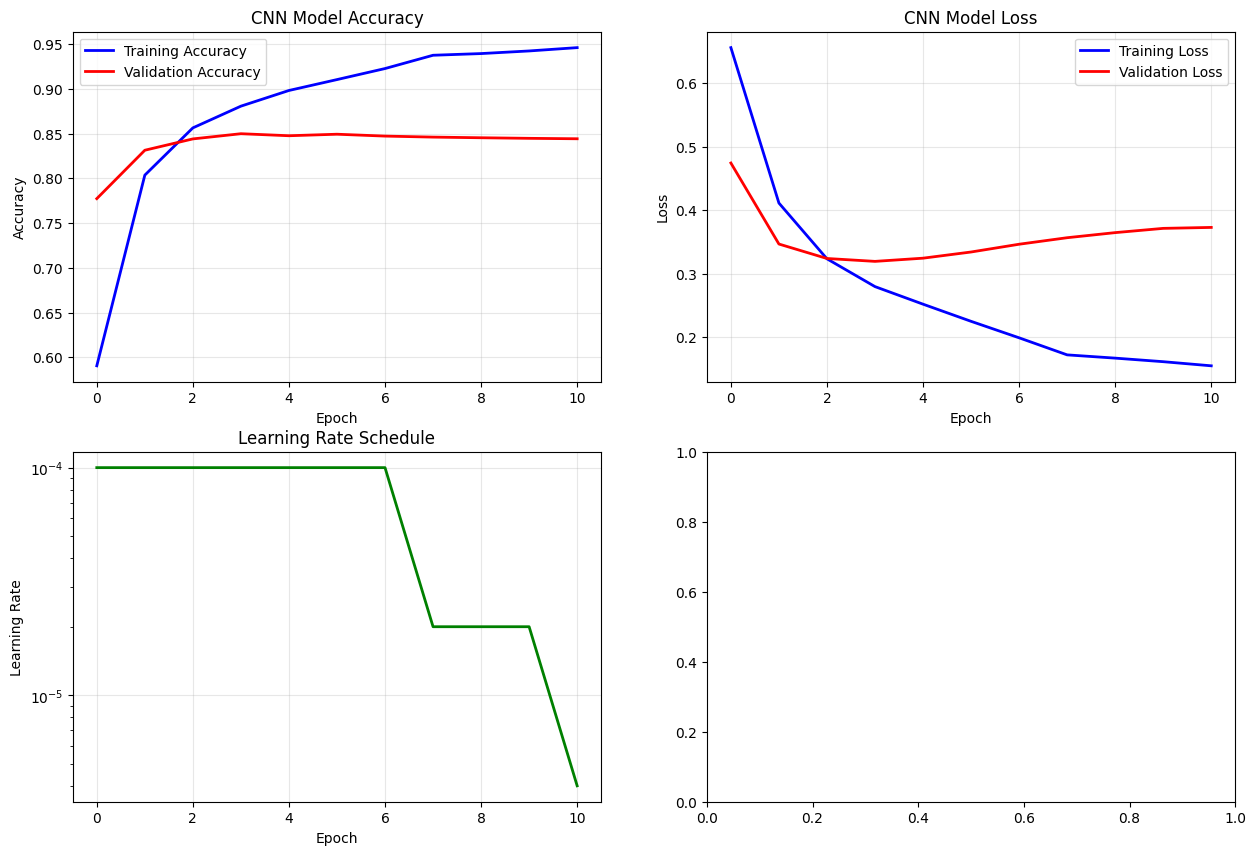

In [90]:
plot_cnn_training_history(history_cnn, "CNN")

In [92]:

# Evaluate on test set
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)

# Print results
print("\n" + "="*60)
print("CNN TRAINING RESULTS")
print("="*60)
print(f"Best Validation Accuracy: {max(history_cnn.history['val_accuracy']):.4f}")
print(f"Best Validation Loss: {min(history_cnn.history['val_loss']):.4f}")
print(f"Final Test Accuracy: {test_accuracy_cnn:.4f}")
print(f"Final Test Loss: {test_loss_cnn:.4f}")
print(f"Total Epochs Trained: {len(history_cnn.history['loss'])}")

if 'lr' in history_cnn.history:
    print(f"Final Learning Rate: {history_cnn.history['lr'][-1]:.2e}")


CNN TRAINING RESULTS
Best Validation Accuracy: 0.8498
Best Validation Loss: 0.3196
Final Test Accuracy: 0.8491
Final Test Loss: 0.3230
Total Epochs Trained: 11
Final Learning Rate: 4.00e-06


In [94]:
# model_cnn.save('../models/my_cnn_model.keras')
# print("CNN model saved successfully!")

CNN model saved successfully!
